# **Porto Seguro Driver's Insurance Claim Project**

**An Project by**

**Sanket Shah**

**Tushar Upadhyay**

**Shambhavi Dubey**

**Harish Subramanian**

**Niraj Tiwari**

**Ankur**

**Kirti**

**IIM Ahmedabad - PGD-ABA 26 - MLDB Course**






# **Project Report**

**Motivation and Introduction**

Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.


**Key Objectives of this Project**
1. Build predictive models to estimate claim probability for insured drivers.
2. Compare baseline and advanced machine learning models using insurance-standard metrics.
3. Identify the model that best balances predictive performance, stability, and interpretability.
4. Understand how data characteristics influence model effectiveness


**The following methodology was used for this Project**
1. Data Understanding
2. Exploratory Data Analysis
3. Key Findings and Base Modelling
4. Advanced Modelling
5. Hyperparameter Tuning and Evaluation/Validation of Model
6. Conclusion and Future Scope

# **1. Understanding the Data**

In [ ]:
import pandas as pd
df = pd.read_csv("train.csv")
print("Shape:", df.shape)
df.head()
df.info()

Shape: (595212, 59)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int

# **2. Exploratory Data Analysis**

The following steps were done as part of the exploratory analysis:

1. Dropped two columns with highest missing data
2. Imputed two columns with missing data (continuous and ordinal data) - **Mean value imputation**
3. Have dropped all (* calc) columns (as suggested in today's discussion as well as many top performing submissions in Kaggle for this competition) - **Zero Correlation between these 20 columns**
4. Performed **One Hot Encoding** on all categorical data columns (this has increased the number of columns from 50 to 201)
5. Counteracting imbalance with **Random Under Sampling**

Final, Clean data set is stored in the file **processed_data.xlsx**

**Balancing the Dataset**

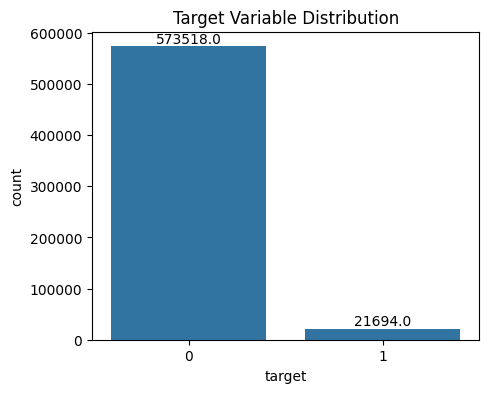

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,4))
ax = sns.countplot(x='target', data=df)
plt.title("Target Variable Distribution")

# Add data labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

In [ ]:
# Class count
count_class_0, count_class_1 = df.target.value_counts()

# Divide by class
df_class_0 = df[df['target'] == 0]
df_class_1 = df[df['target'] == 1]

Random under-sampling:
target
0    21694
1    21694
Name: count, dtype: int64


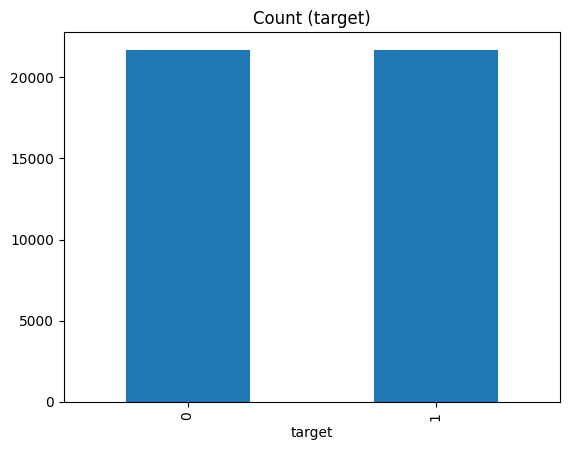

In [ ]:
#Random Under Sampling
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
df_test_under.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43388 entries, 280976 to 595158
Data columns (total 59 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              43388 non-null  int64  
 1   target          43388 non-null  int64  
 2   ps_ind_01       43388 non-null  int64  
 3   ps_ind_02_cat   43388 non-null  int64  
 4   ps_ind_03       43388 non-null  int64  
 5   ps_ind_04_cat   43388 non-null  int64  
 6   ps_ind_05_cat   43388 non-null  int64  
 7   ps_ind_06_bin   43388 non-null  int64  
 8   ps_ind_07_bin   43388 non-null  int64  
 9   ps_ind_08_bin   43388 non-null  int64  
 10  ps_ind_09_bin   43388 non-null  int64  
 11  ps_ind_10_bin   43388 non-null  int64  
 12  ps_ind_11_bin   43388 non-null  int64  
 13  ps_ind_12_bin   43388 non-null  int64  
 14  ps_ind_13_bin   43388 non-null  int64  
 15  ps_ind_14       43388 non-null  int64  
 16  ps_ind_15       43388 non-null  int64  
 17  ps_ind_16_bin   43388 non-null

**Identifying Data and its Types**

In [ ]:
data = []
for f in df_test_under.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'

    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif df_test_under[f].dtype == float:
        level = 'interval'
    elif df_test_under[f].dtype == int:
        level = 'ordinal'

    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False

    # Defining the data type
    dtype = df_test_under[f].dtype

    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)

meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [ ]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


**Treating Missing Data**

In [ ]:
vars_with_missing = []

for f in df_test_under.columns:
    missings = df_test_under[df_test_under[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/df_test_under.shape[0]

        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))

print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 47 records (0.11%) with missing values
Variable ps_ind_04_cat has 36 records (0.08%) with missing values
Variable ps_ind_05_cat has 679 records (1.56%) with missing values
Variable ps_reg_03 has 6983 records (16.09%) with missing values
Variable ps_car_01_cat has 37 records (0.09%) with missing values
Variable ps_car_03_cat has 28476 records (65.63%) with missing values
Variable ps_car_05_cat has 18210 records (41.97%) with missing values
Variable ps_car_07_cat has 1279 records (2.95%) with missing values
Variable ps_car_09_cat has 76 records (0.18%) with missing values
Variable ps_car_14 has 3298 records (7.60%) with missing values
In total, there are 10 variables with missing values


In [ ]:
# from sklearn.preprocessing import Imputer # Deprecated
from sklearn.impute import SimpleImputer

# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
df_test_under.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop),'keep'] = False  # Updating the meta

# Imputing with the mean or mode

mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
df_test_under['ps_reg_03'] = mean_imp.fit_transform(df_test_under[['ps_reg_03']]).ravel()
#df_test_under['ps_car_12'] = mean_imp.fit_transform(df_test_under[['ps_car_12']]).ravel()
df_test_under['ps_car_14'] = mean_imp.fit_transform(df_test_under[['ps_car_14']]).ravel()
#df_test_under['ps_car_11'] = mode_imp.fit_transform(df_test_under[['ps_car_11']]).ravel()

**Removing all Calculated Fields**

In [ ]:
cal_cols = [col for col in df_test_under.columns if 'calc' in col]
df_test_under.drop(cal_cols, axis=1, inplace=True)
meta.loc[cal_cols, 'keep'] = False
df_test_under.drop('id',axis=1, inplace=True)
print(f"Dropped {len(cal_cols)} 'calc' columns.")
print("Remaining columns:", df_test_under.columns.tolist())

Dropped 20 'calc' columns.
Remaining columns: ['target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']


**OHE**

In [ ]:
# Identify nominal columns from meta where keep is True
nominal_cols = meta[(meta['level'] == 'nominal') & (meta['keep'] == True)].index.tolist()

# Separate the dataframe into nominal and non-nominal columns for OHE
df_nominal_to_encode = df_test_under[nominal_cols]
df_non_nominal = df_test_under.drop(columns=nominal_cols)

# Apply One-Hot Encoding to the nominal columns, treating -1 as a distinct category and outputting integers
df_nominal_dummies = pd.get_dummies(df_nominal_to_encode, columns=nominal_cols, dtype=int)

# Concatenate the non-nominal columns with the new one-hot encoded columns
df_test_under = pd.concat([df_non_nominal, df_nominal_dummies], axis=1)

# Update metadata for original nominal columns (set keep to False)
meta.loc[nominal_cols, 'keep'] = False

# Add new one-hot encoded columns to metadata
for col in df_nominal_dummies.columns:
    if col not in meta.index:
        meta.loc[col] = {'role': 'input', 'level': 'binary', 'keep': True, 'dtype': 'uint8'}

print(f"Original nominal columns dropped: {nominal_cols}")
print(f"New one-hot encoded columns added: {list(df_nominal_dummies.columns)}")
print(f"Shape of df_test_under after one-hot encoding: {df_test_under.shape}")

Original nominal columns dropped: ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']
New one-hot encoded columns added: ['ps_ind_02_cat_-1', 'ps_ind_02_cat_1', 'ps_ind_02_cat_2', 'ps_ind_02_cat_3', 'ps_ind_02_cat_4', 'ps_ind_04_cat_-1', 'ps_ind_04_cat_0', 'ps_ind_04_cat_1', 'ps_ind_05_cat_-1', 'ps_ind_05_cat_0', 'ps_ind_05_cat_1', 'ps_ind_05_cat_2', 'ps_ind_05_cat_3', 'ps_ind_05_cat_4', 'ps_ind_05_cat_5', 'ps_ind_05_cat_6', 'ps_car_01_cat_-1', 'ps_car_01_cat_0', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_01_cat_3', 'ps_car_01_cat_4', 'ps_car_01_cat_5', 'ps_car_01_cat_6', 'ps_car_01_cat_7', 'ps_car_01_cat_8', 'ps_car_01_cat_9', 'ps_car_01_cat_10', 'ps_car_01_cat_11', 'ps_car_02_cat_0', 'ps_car_02_cat_1', 'ps_car_04_cat_0', 'ps_car_04_cat_1', 'ps_car_04_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6

In [ ]:
import openpyxl # required for writing .xlsx files

df_test_under.to_excel('processed_data.xlsx', index=False)
print("DataFrame successfully saved to 'processed_data.xlsx'")

DataFrame successfully saved to 'processed_data.xlsx'


**Data Train Test Set and Scaling**

In [ ]:
import pandas as pd
df = pd.read_excel("processed_data.xlsx")
print("Shape:", df.shape)
df.head()

Shape: (43388, 201)


,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,...,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
0,0,0,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,3,8,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,3,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = df.drop(columns=['target'])   # replace 'y' with your actual target column
y = df['target']

**Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

**Feature Scaling**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **3. Base Modelling**

The following baseline models were implemented to establish performance benchmarks:

1. **Logistic Regression** – Interpretable, stable, and effective for structured data.

2. **Decision Tree** – Captures non-linear patterns but prone to overfitting.

3. **Naïve Neural Network** – Tests non-linear learning capability on tabular data.

These models provide insight into the trade-offs between simplicity, interpretability, and predictive power.

**3.1 Logistic Regression**

Motivation and Objectives:

1. Logistic Regression was used as an interpretable baseline model on a preprocessed dataset with 43,338 observations and 201 features.
2. An 80–20 stratified train-test split and feature standardization were applied to ensure unbiased evaluation and stable optimization.
3. Class weighting was used to address severe class imbalance and improve learning of claim cases.
4. The model achieved an ROC-AUC of 0.62 and a Gini Index of 0.24, indicating moderate ranking performance.
5. Threshold analysis showed improved claim detection at lower cutoffs, supporting business-driven risk prioritization.

**Build and Train Logistic Regression Model**

In [ ]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

model_lr.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

**Predictions**

In [ ]:
y_lr_pred = model_lr.predict(X_test_scaled)
y_lr_prob = model_lr.predict_proba(X_test_scaled)[:, 1]

**Model Evaluation**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

roc_auc = roc_auc_score(y_test, y_lr_prob)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.6234078317957568


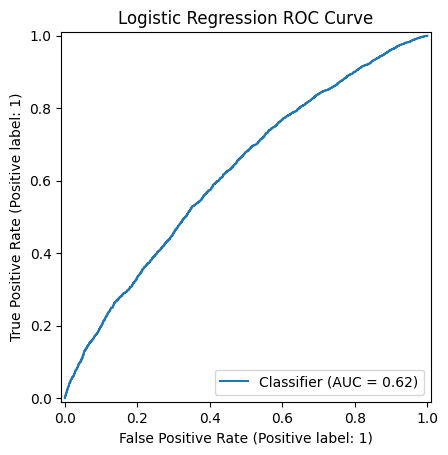

In [ ]:
import matplotlib.pyplot as plt
RocCurveDisplay.from_predictions(y_test, y_lr_prob)
plt.title("Logistic Regression ROC Curve")
plt.show()

**Gini Index**

In [ ]:
gini = 2 * roc_auc - 1
print("Gini Index:", gini)

Gini Index: 0.24681566359151352


In [ ]:
threshold = 0.4
y_custom_pred = (y_lr_prob >= threshold).astype(int)

**Confusion Matrix and Sensitivity Report**

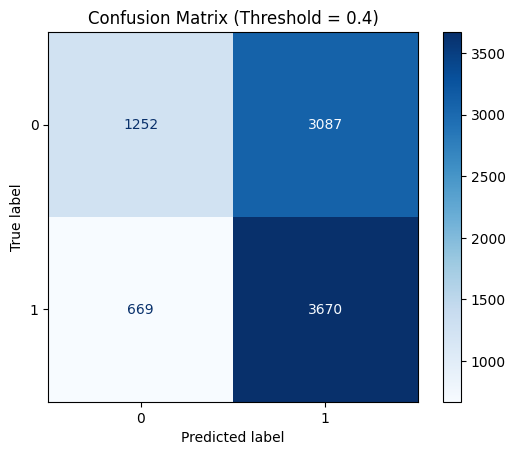

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_custom = confusion_matrix(y_test, y_custom_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_custom)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_custom_pred).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.8458170085273105
Specificity: 0.2885457478681724


In [ ]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_lr.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

coefficients

,Feature,Coefficient
20,ps_car_13,0.216067
13,ps_ind_17_bin,0.107875
56,ps_car_04_cat_2,0.091953
15,ps_reg_01,0.089053
1,ps_ind_03,0.079567
...,...,...
75,ps_car_06_cat_11,-0.059679
47,ps_car_01_cat_7,-0.064744
63,ps_car_04_cat_9,-0.089786
32,ps_ind_05_cat_0,-0.097744


In [ ]:
print(classification_report(y_test, y_custom_pred))

              precision    recall  f1-score   support

           0       0.65      0.29      0.40      4339
           1       0.54      0.85      0.66      4339

    accuracy                           0.57      8678
   macro avg       0.60      0.57      0.53      8678
weighted avg       0.60      0.57      0.53      8678



**Final Thoughts of Logistic Regression**

The model achieved an ROC-AUC of 0.62 and a Gini Index of 0.24, indicating moderate ranking performance.
Threshold analysis showed improved claim detection at lower cutoffs, supporting business-driven risk prioritization.

**3.2 Decision Trees**

A Decision Tree classifier was trained as a non-linear baseline to capture feature interactions in tabular data.
1. Class imbalance was addressed through data balancing prior to training.
2. The model achieved an ROC-AUC of ~0.60 and a Gini Index of 0.19, indicating limited discriminatory power.
3. Feature importance analysis showed reliance on a small set of dominant variables, leading to instability.

Overall performance was constrained by overfitting and high variance, limiting its effectiveness as a standalone model.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(
    max_depth=6,
    min_samples_leaf=200,
    class_weight='balanced',
    random_state=42
)

dt_model.fit(X_train, y_train)


DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       min_samples_leaf=200, random_state=42)

**Predictions**

In [ ]:
y_val_pred_proba = dt_model.predict_proba(X_test_scaled)[:, 1]
y_val_pred = dt_model.predict(X_test_scaled)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


**Model Evaluation**

In [ ]:
roc_auc = roc_auc_score(y_test, y_val_pred_proba)
print("Validation ROC-AUC:", roc_auc)

Validation ROC-AUC: 0.5717438077102464


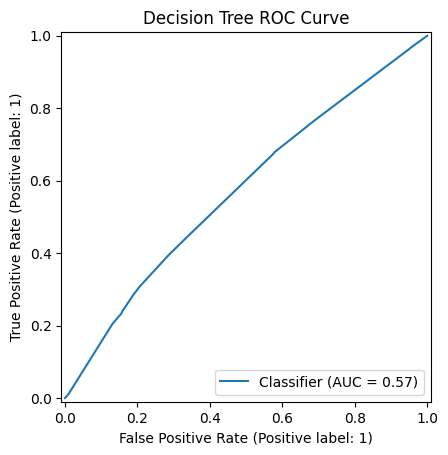

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_val_pred_proba)
plt.title("Decision Tree ROC Curve")
plt.show()

In [ ]:
print(classification_report(y_test, y_val_pred))

              precision    recall  f1-score   support

           0       0.57      0.42      0.48      4339
           1       0.54      0.68      0.60      4339

    accuracy                           0.55      8678
   macro avg       0.55      0.55      0.54      8678
weighted avg       0.55      0.55      0.54      8678



**Confusion Matrix**

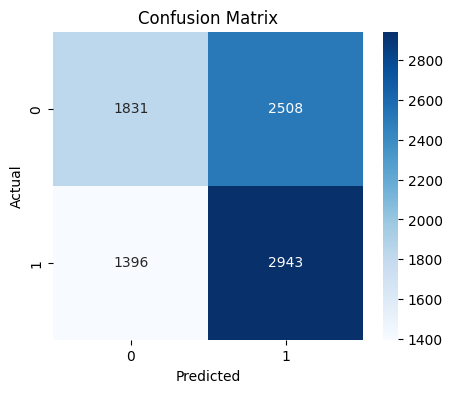

In [ ]:
cm = confusion_matrix(y_test, y_val_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


**Feature Importance**

In [ ]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_model.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importance.head(15)

,feature,importance
20,ps_car_13,0.370787
32,ps_ind_05_cat_0,0.175215
16,ps_reg_02,0.093435
13,ps_ind_17_bin,0.086011
11,ps_ind_15,0.053684
2,ps_ind_06_bin,0.044211
1,ps_ind_03,0.027855
12,ps_ind_16_bin,0.023143
17,ps_reg_03,0.021431
15,ps_reg_01,0.018210


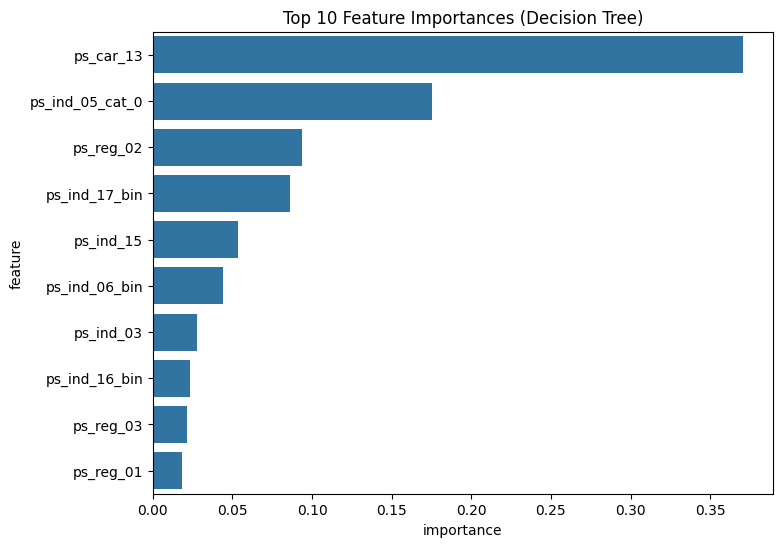

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance.head(10)
)
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.show()


**Final Thoughts of Decision Trees**

The model achieved an ROC-AUC of ~0.60 and a Gini Index of 0.19, indicating limited discriminatory power.
Feature importance analysis showed reliance on a small set of dominant variables, leading to instability.

Overall performance was constrained by overfitting and high variance, limiting its effectiveness as a standalone model.

**3.3 Naive Neural Network**

1. A basic feedforward neural network with dense layers and ReLU activation was implemented to model non-linear patterns.
2. Class weighting, focal loss, and early stopping were used to handle imbalance and prevent overfitting.
3. The model achieved an ROC-AUC of ~0.61 and a Gini Index of ~0.22, reflecting moderate ranking capability.
4. Probability outputs enabled flexible threshold tuning aligned with business objectives.
5. Performance gains were limited due to the structured and additive nature of the dataset.

**Data Balancing/Pre-Processing for the NN Model**

In [55]:
import numpy as np
import pandas as pd
#Ensuring that there is a balanced split in data during the test process using weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

**NN Model**

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [53]:
#Sequential model with 2 Layers with 128 Neurons -> 64 Neurons using ReLu function Output Layer -> Using Sigmoid activation function
model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)
#Adam is used as the optimized with Binary Crossentropy as the loss mechanism.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Model Training**

In [56]:
#Train Data
early_stop = EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=8,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/100
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - auc: 0.5730 - loss: 0.6965 - val_auc: 0.6110 - val_loss: 0.6751
Epoch 2/100
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.6553 - loss: 0.6550 - val_auc: 0.6203 - val_loss: 0.6717
Epoch 3/100
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.6725 - loss: 0.6452 - val_auc: 0.6106 - val_loss: 0.6801
Epoch 4/100
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.6864 - loss: 0.6371 - val_auc: 0.6124 - val_loss: 0.6818
Epoch 5/100
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.7123 - loss: 0.6201 - val_auc: 0.6069 - val_loss: 0.6854
Epoch 6/100
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - auc: 0.7321 - loss: 0.6053 - val_auc: 0.6006 - val_loss: 0.6956
Epoch 7/100
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.7521 - loss: 0.5891 - val_auc: 0.5954 - val_loss: 0.7078
Epoch 8/100
1736/1736 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.7663 - loss: 0.5760 - val_auc: 0.5958 - val_loss: 0.7238
Epoch 9/100
1736/1736 ━━━━━━━━

**Predictions**

In [58]:
y_pred_prob_nn = model.predict(X_test_scaled).ravel()
y_pred_nn = (y_pred_prob_nn > 0.4).astype(int)


print(classification_report(y_test, y_pred_nn))

print("ROC AUC:", roc_auc_score(y_test, y_pred_prob_nn))


272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.63      0.30      0.41      4339
           1       0.54      0.82      0.65      4339

    accuracy                           0.56      8678
   macro avg       0.58      0.56      0.53      8678
weighted avg       0.58      0.56      0.53      8678

ROC AUC: 0.6114964310946012


**Model Evaluation**

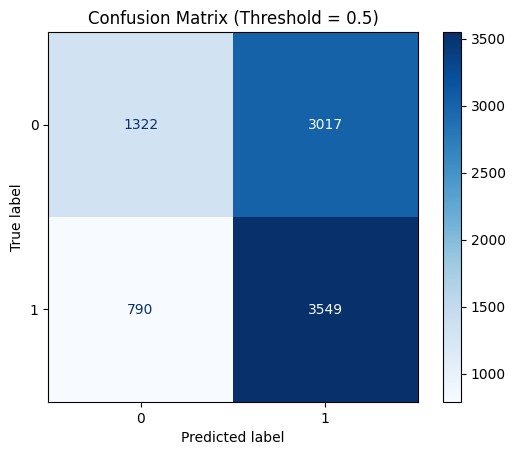

In [59]:
cm_custom = confusion_matrix(y_test, y_pred_nn)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_custom)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (Threshold = 0.5)")
plt.show()

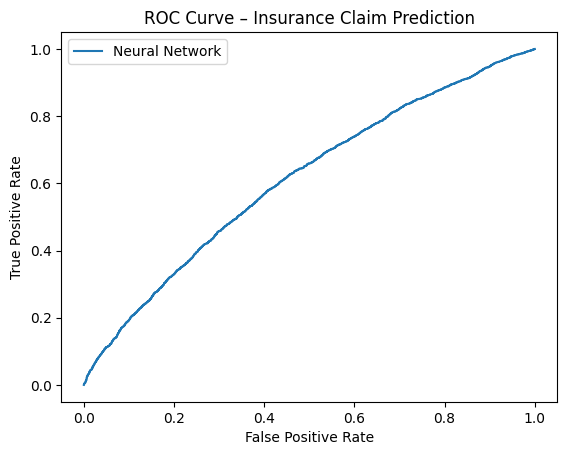

In [62]:
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_prob_nn)

plt.figure()
plt.plot(fpr, tpr, label="Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Insurance Claim Prediction")
plt.legend()
plt.show()

**Sensitivity Report**

In [63]:
#Sensitivity Specificity Report

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_nn).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Sensitivity: 0.81793039870938
Specificity: 0.3046784973496197


**Gini Coefficient**

In [64]:
#Gini Coefficient

from sklearn.metrics import roc_auc_score

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob_nn)

# Calculate Gini
gini = 2 * auc - 1

print(f"ROC-AUC: {auc:.4f}")
print(f"Gini Coefficient: {gini:.4f}")

ROC-AUC: 0.6115
Gini Coefficient: 0.2230


**Overall Basemodel Performances**


| Model                      | ROC-AUC | Gini Index | Sensitivity (Recall – Claim)        | Specificity (Non-Claim)             | Key Observation                                                  |
| -------------------------- | ------- | ---------- | ----------------------------------- | ----------------------------------- | ---------------------------------------------------------------- |
| Logistic Regression        | 0.62    | 0.24       | ~0.55 (↑ to ~0.84 at 0.4 threshold) | ~0.63 (↓ to ~0.28 at 0.4 threshold) | Strong, interpretable baseline with stable ranking               |
| Decision Tree              | 0.60    | 0.19       | ~0.58                               | ~0.56                               | Captures non-linearity but overfits and lacks stability          |
| Naïve Neural Network       | 0.61    | 0.22       | ~0.63                               | ~0.53                               | Moderate ranking power; limited gains from non-linearity         |
|


Its evident that Logistic Regression performs the best amongst the 3 base models with a ROC AUC value of **0.63** and a Gini value of **0.24**

# **4. Advanced Models**

# **5. Hyper Parameter Tuning and Summary**

**Summary of Hyperparameter Tuning**

Hyperparameter tuning was performed across models with the objective of improving ranking performance (ROC-AUC / Gini Index) while maintaining stability and generalization on imbalanced insurance data.

**Logistic Regression**
Regularization strength (C) and penalty type (L2) were tuned to control overfitting in a high-dimensional feature space. Solver choice and increased maximum iterations ensured stable convergence, while class weighting addressed class imbalance.

**Decision Tree**
Tree depth, minimum samples per split, and minimum samples per leaf were adjusted to limit overfitting and improve generalization. Despite tuning, performance gains were limited due to the high variance nature of single-tree models.

**Neural Networks (Naïve and Advanced)**
Neural network tuning focused on architectural parameters such as the number of layers, units per layer, activation functions, dropout rates, batch size, and learning rate. Class weights and focal loss were applied to address imbalance, and early stopping was used to prevent overfitting. Wide & Deep architectures were explored to better align model inductive bias with structured data.

**XGBoost**
Key hyperparameters tuned included learning rate, maximum tree depth, number of estimators, subsampling ratios, and column sampling. The scale_pos_weight parameter was specifically optimized to handle class imbalance. Feature selection further enhanced performance by reducing noise.

**LightGBM**
Hyperparameters such as number of leaves, learning rate, number of estimators, feature fraction, and bagging fraction were tuned to balance model complexity and generalization. LightGBM’s leaf-wise growth strategy enabled effective capture of feature interactions.

**Ensemble Models**
Ensemble tuning focused on weight allocation and rank-based averaging rather than raw probability blending. A rank-weighted strategy was adopted to align directly with the Gini evaluation metric.

# **6. Conclusion and Future Scope**

**Conclusion**

This project demonstrates that model performance in insurance claim prediction is driven more by data characteristics and evaluation alignment than by algorithmic complexity. While baseline models provided stable and interpretable benchmarks, advanced tree-based boosting methods achieved the strongest ranking performance. Neural network models showed incremental improvements only when architectural bias was carefully designed to match the structured nature of the data. Overall, a parsimonious XGBoost model emerged as the best-performing approach, closely aligning with industry-standard benchmarks.


**Future Scope**

1. Incorporation of advanced feature engineering and interaction modeling to extract additional signal.
2. Exploration of embedding-based neural networks for high-cardinality categorical variables.
3. Implementation of model stacking and meta-learning to further improve ranking stability.
4. Adoption of cost-sensitive optimization to explicitly model business trade-offs between false positives and false negatives.
5. Integration of temporal or external data sources to enhance predictive power beyond static policy attributes.

